In [27]:
!pip list

Package                                  Version
---------------------------------------- ---------------
absl-py                                  2.1.0
aiohappyeyeballs                         2.4.4
aiohttp                                  3.11.10
aiosignal                                1.3.1
alembic                                  1.14.0
altair                                   5.4.1
annotated-types                          0.7.0
anyio                                    4.6.2.post1
appdirs                                  1.4.4
appnope                                  0.1.3
asgiref                                  3.8.1
asttokens                                2.4.1
astunparse                               1.6.3
attrs                                    24.2.0
auth0-python                             4.7.2
axios                                    0.4.0
backcall                                 0.2.0
backoff                                  2.2.1
bcrypt                                

In [41]:

import numpy as np 
from tqdm import tqdm
import cv2
import os
from os import listdir
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from sklearn.utils import shuffle #s

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
image_dir = 'brain_tumor_dataset/'

# Iterate directory
for type in ["no", "yes"]: 
    subdir_path = os.path.join(image_dir, type)
    count = 0
    for path in os.listdir(subdir_path):
        if os.path.isfile(os.path.join(subdir_path, path)):
            count += 1
    print(f"{type}: {count} images")

#As we can see our dataset is imbalanced with ratio of 1:2 for negative:positive instances
#This suggests we should atleast double the amount of negative instances in comparison to positive 
#instances to balance the dataset to avoid bias in our model

no: 73 images
yes: 150 images


In [ ]:

# os.makedirs('dataset/augmented-images')
# os.makedirs('dataset/augmented-images/yes')
# os.makedirs('dataset/augmented-images/no')


In [115]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

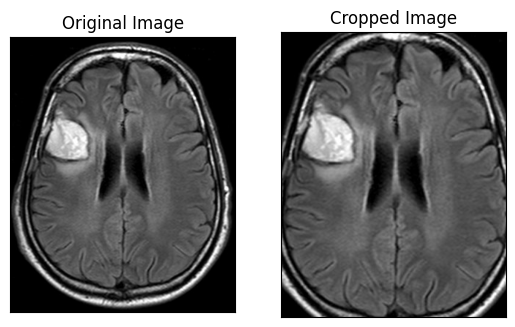

In [109]:
ex_img = cv2.imread('brain_tumor_dataset/yes/Y7.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

#Example of the crop function performance

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir, label_prefix):

    data_gen = ImageDataGenerator(rotation_range=10, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                 )
    
    counter = 1

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = crop_brain_contour(image, False)
        image = image.reshape((1,)+image.shape)


        i = 0
        for batch in data_gen.flow(x = image, batch_size = 1, save_format='jpg'):
            save_path = os.path.join(save_to_dir, f"{label_prefix}{counter}.jpg")
            cv2.imwrite(save_path, batch[0])

            i += 1
            counter += 1

            if i > n_generated_samples:
                break


augmented_data_path ='dataset/augmented-images/'

augment_data(file_dir = image_dir + 'no', n_generated_samples = 8, save_to_dir = augmented_data_path + 'no', label_prefix = 'N')
augment_data(file_dir = image_dir + 'yes',n_generated_samples = 4, save_to_dir = augmented_data_path + 'yes', label_prefix = 'Y')


                

In [119]:


def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    
    for directory in dir_list:
        for filename in listdir(directory):

            image = cv2.imread(directory + '/' + filename)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)

            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)

            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [120]:
augmented_yes = augmented_data_path + 'yes'
augmented_no = augmented_data_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (256, 256)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1407
X shape is: (1407, 256, 256, 3)
y shape is: (1407, 1)


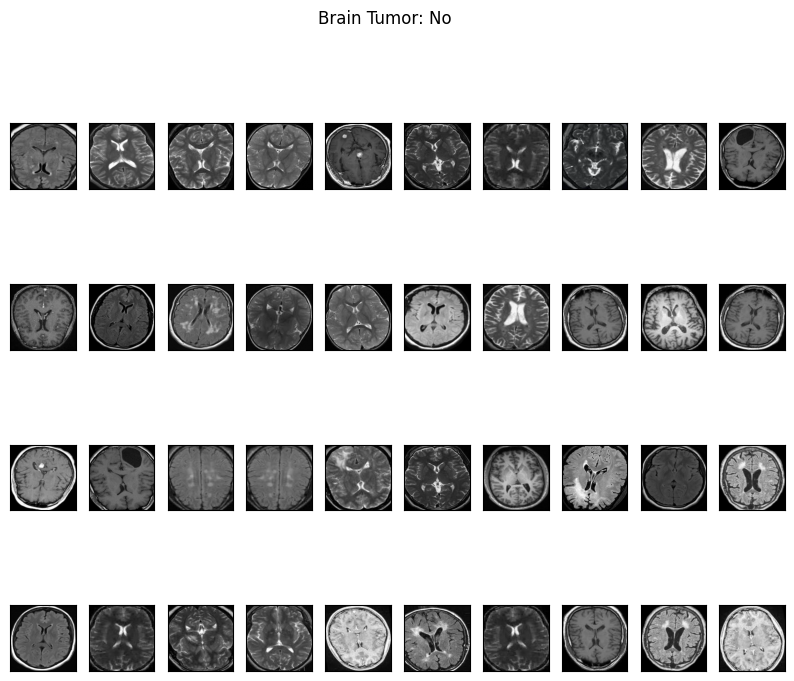

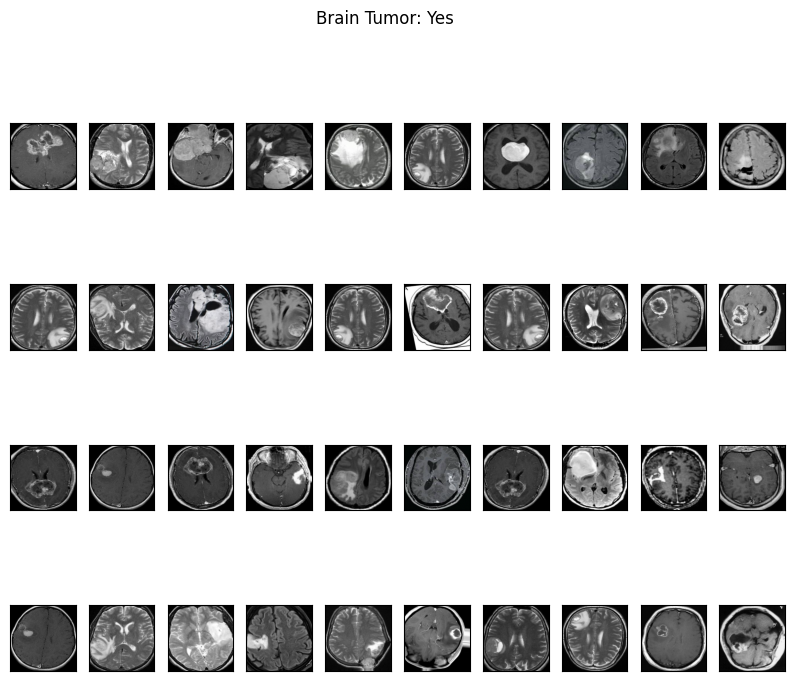

In [45]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

plot_sample_images(X, y)